# Demonstration of the MA code's ability to decode social information from song

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, adapt='MA'):
    t = np.arange(len(i_s))*DT
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        if adapt == 'MA':
            vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        elif adapt == 'lin':
            vs[ct, :] = x_s*(i_s[ct]-a_ss[ct-1, :]) + x_p*(i_p[ct]-a_ps[ct-1, :])
        
        # update integral
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t

In [5]:
def get_basis(motif_basis, tau_r, tau_a, x_s, x_p, adapt, alpha):
    basis = np.nan*np.zeros((len(tau_r), len(motif_basis)))
    rs_full = []

    for cmotif, motif in enumerate(motif_basis):
        i_s = (motif == 1).astype(float)
        i_p = (motif == 2).astype(float)

        t_snp = np.arange(len(motif))*DT

        rs = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, adapt=adapt)[0]

        basis[:, cmotif] = rs[-1, :]
        rs_full.append(rs)
        
    rgr = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    w_readout = rgr.fit(basis.T, np.eye(len(motif_basis))).coef_.T
    
    return basis, w_readout, rs_full

In [6]:
def make_rand_song(z, motif_basis, t_pause, t_total, allow_flips=False, allow_scrambling=False, jitter=0):
    
    pause_0 = np.repeat(0, int(round(t_pause/DT)))
    
    t_sng = np.arange(0, t_total, DT)
    
    sng_segs = [[]]
    t_motifs = []
    imotifs = []
    
    while len(cc(sng_segs))*DT < (t_total-t_pause):
        
        imotif = np.random.choice(range(len(z)), p=z/z.sum())
        
        motif = motif_basis[imotif]
        
        if jitter:
            pause = np.repeat(0, int(round(np.random.uniform(t_pause-jitter/2, t_pause+jitter/2)/DT)))
        else:
            pause = pause_0
            
        sng_segs.append(pause)
        
        if allow_flips:
            # sng_segs.append(chirp[np.random.permutation(len(chirp))])
            if np.random.rand() < .5:
                sng_segs.append(motif)
            else:
                sng_segs.append(motif[::-1])
        elif allow_scrambling:
            sng_segs.append(motif[np.random.permutation(len(motif))])
        else:
            sng_segs.append(motif)
        
        t_motifs.append(DT*(len(cc(sng_segs)) - len(motif)/2))
        imotifs.append(imotif)
    
    sng_segs.append(pause)
    sng = cc(sng_segs)
    
    if len(sng) > len(t_sng):
        sng = sng[:len(t_sng)]
    else:
        sng = cc([sng, np.repeat(0, len(t_sng)-len(sng))])
    
    return sng, t_sng, t_motifs, imotifs

In [7]:
def get_alignment(r_0, r_1):
    r_0_hat = r_0/np.linalg.norm(r_0)
    r_1_hat = r_1/np.linalg.norm(r_1)
    return r_0_hat@r_1_hat

In [8]:
N = 20
TAU_R = np.random.uniform(120, 120, N)
TAU_A = np.random.uniform(.1, 2, N)
X_S = np.random.uniform(0, 1, N)
X_P = np.random.uniform(0, 1, N)
# minh = np.random.rand(N) < .5
# x_s[minh] *= -1
# x_p[minh] *= -1

Goal here is proof of concept, so may have to run a few times to get a good chirp codebook.

0.9374883870613749
0.8793116023360178
0.6870893347095124


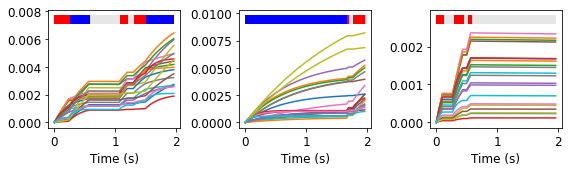

In [9]:
# pre-set basis (taken from natural song)
NTRAIT = 3
motif_basis = np.array([
    [2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2],
    [2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])

ALPHA = 1e-7
basis_ma, w_ma, rs_full_ma = get_basis(motif_basis, TAU_R, TAU_A, X_S, X_P, adapt='MA', alpha=ALPHA)
basis_lin, w_lin, rs_full_lin = get_basis(motif_basis, TAU_R, TAU_A, X_S, X_P, adapt='lin', alpha=ALPHA)

fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), tight_layout=True)

for cmotif, motif in enumerate(motif_basis):
    # snp = snps[isnp]
    t_motif = np.arange(len(motif))*DT
    
    axs[cmotif].plot(t_motif, rs_full_ma[cmotif])
    plot_b(axs[cmotif], t_motif, motif, [0, t_motif.max(), 1.1*rs_full_ma[cmotif].max(), 1.2*rs_full_ma[cmotif].max()], c=[(.9, .9, .9), 'b', 'r'])
    set_plot(axs[cmotif], x_label='Time (s)')
    
for imotif_0 in range(len(motif_basis)):
    for imotif_1 in range(imotif_0+1, len(motif_basis)):
        print(get_alignment(basis_ma[:, imotif_0], basis_ma[:, imotif_1]))

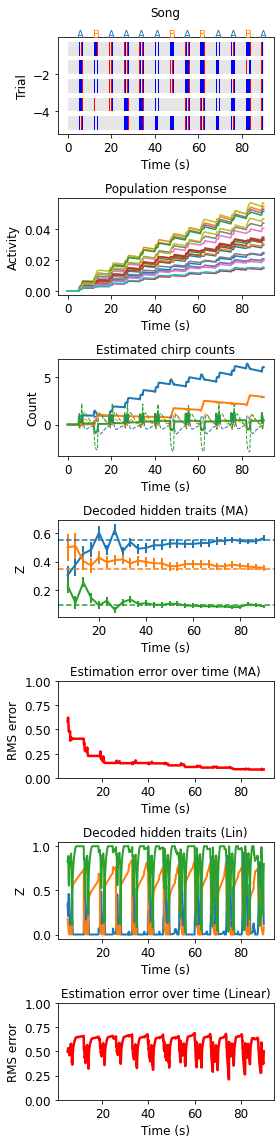

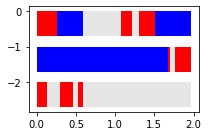

In [12]:
Z = np.array([.55, .35, .1])  # hidden information

T_PAUSE = 5
T_TOTAL = 90

NTR = 30

fig, axs = plt.subplots(7, 1, figsize=(4, 16), tight_layout=True)

rms_ma_all = []
rms_lin_all = []

z_ma_all = []
z_lin_all = []

for ctr in range(NTR):

    sng, t_sng, t_motifs, imotifs = make_rand_song(Z, motif_basis, T_PAUSE, T_TOTAL)

    i_s = (sng == 1)
    i_p = (sng == 2)

    rs_ma = smlt(i_s, i_p, TAU_R, TAU_A, X_S, X_P)[0]
    rs_lin = smlt(i_s, i_p, TAU_R, TAU_A, X_S, X_P, adapt='lin')[0]
    
    # plot song
    if ctr < 5:
        plot_b(axs[0], t_sng, sng, [0, t_sng.max(), -ctr-.25, -ctr-1], c=[(.9, .9, .9), 'b', 'r'])
        set_plot(axs[0], y_label='Activation', title=f'Population response')
    
    if ctr == 0:
        for t_motif, imotif in zip(t_motifs, imotifs):
            axs[0].text(t_motif, 0, ['A', 'B', 'C'][imotif], color=colors[imotif], ha='center')
    
    y_ma = rs_ma@w_ma
    y_lin = rs_lin@w_lin
    
    z_ma = np.clip(y_ma / y_ma.sum(1)[:, None], 0, 1)
    z_lin = np.clip(y_lin / y_lin.sum(1)[:, None], 0, 1)
    
    rms_ma = np.sqrt(np.mean((z_ma - Z[None, :])**2, axis=1))
    rms_lin = np.sqrt(np.mean((z_lin - Z[None, :])**2, axis=1))
    
    if ctr == 0:
        
        # plot MA responses
        axs[1].plot(t_sng, rs_ma)

        # plot decoded chirp counts
        for w_ma_, color in zip(w_ma.T, colors):
            axs[2].plot(t_sng, rs_ma@w_ma_, lw=2, c=color)

        for w_lin_, color in zip(w_lin.T, colors):
            axs[2].plot(t_sng, rs_lin@w_lin_, lw=1, c=color, ls='--')

        # plot true Z
        for d, z in enumerate(Z):
            axs[3].axhline(z, color=colors[d], ls='--')
            
    z_ma_all.append(z_ma.copy())
    z_lin_all.append(z_lin.copy())
    
    rms_ma_all.append(rms_ma.copy())
    rms_lin_all.append(rms_lin.copy())
    
step = 100
for d in range(len(Z)):
    axs[3].errorbar(t_sng[::step], np.mean(z_ma_all, axis=0)[:, d][::step], yerr=stats.sem(z_ma_all, axis=0)[:, d][::step], c=colors[d], lw=2)
    axs[5].plot(t_sng, np.mean(z_lin_all, axis=0)[:, d], c=colors[d], lw=2)


axs[4].plot(t_sng, np.mean(rms_ma_all, axis=0), c='r', lw=2.5)
axs[6].plot(t_sng, np.mean(rms_lin_all, axis=0), c='r', lw=2.5)
        
for ax in axs:
    set_plot(ax, x_label='Time (s)')
    
set_plot(axs[0], y_label='Trial', title='Song\n')
set_plot(axs[1], y_label='Activity', title='Population response')
set_plot(axs[2], y_label='Count', title='Estimated chirp counts')
set_plot(axs[3], y_label='Z', title='Decoded hidden traits (MA)')
set_plot(axs[4], y_lim=(0, 1), y_label='RMS error', title='Estimation error over time (MA)')
set_plot(axs[5], y_label='Z', title='Decoded hidden traits (Lin)')
set_plot(axs[6], y_lim=(0, 1), y_label='RMS error', title='Estimation error over time (Linear)')

fig.savefig('ms/fig_5_social_info_3d.svg')

fig, ax = plt.subplots(1, 1, figsize=(3, 2), tight_layout=True)
for cmotif, motif in enumerate(motif_basis):
    t_motif = np.arange(len(motif))*DT
    plot_b(ax, t_motif, motif, [0, t_motif.max(), -cmotif, -cmotif-.7], c=[(.9, .9, .9), 'b', 'r'])
    
fig.savefig('ms/fig_5_social_info_3d_motifs.svg')

## Repeat while including motif synonyms

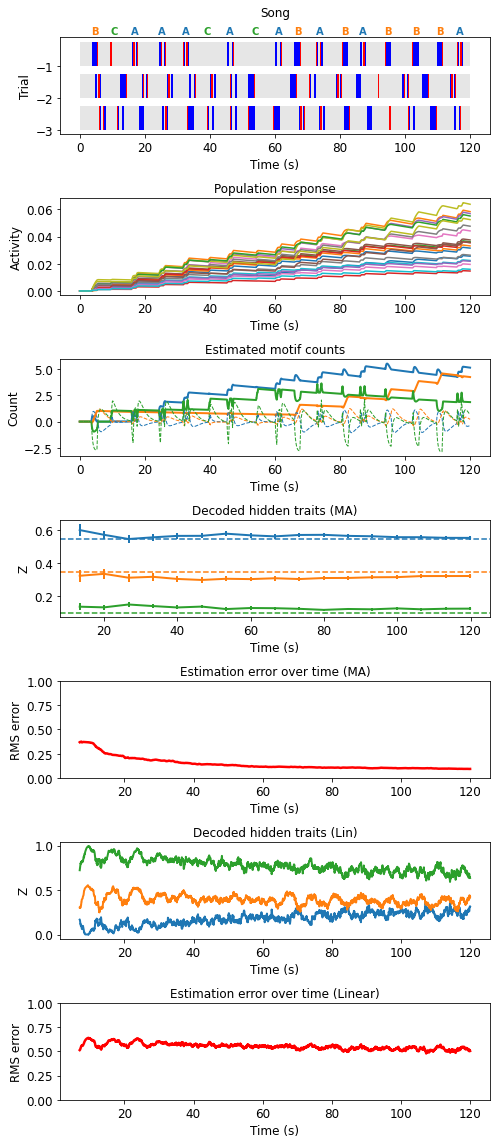

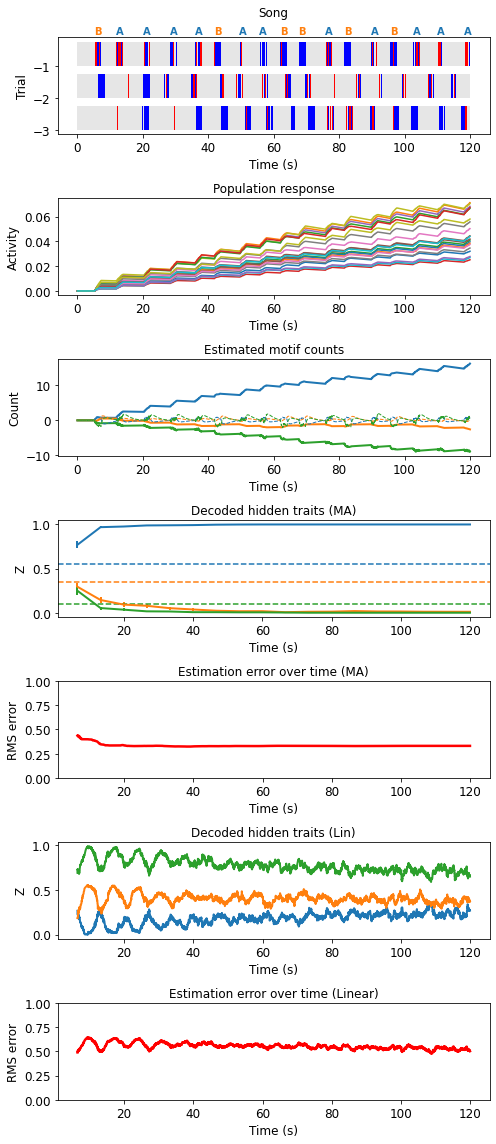

In [15]:
Z = np.array([.55, .35, .1])  # hidden information

T_PAUSE = 5
JITTER = 3
T_TOTAL = 120

NTR = 100

PLOT_STEP = 200

trial_types = ['allow_flip', 'allow_scramble']

for trial_type in trial_types:
    
    fig, axs = plt.subplots(7, 1, figsize=(7, 16), tight_layout=True)

    rms_ma_all = []
    rms_lin_all = []

    z_ma_all = []
    z_lin_all = []
    
    for ctr in range(NTR):

        if trial_type == 'allow_flip':
            sng, t_sng, t_motifs, imotifs = make_rand_song(Z, motif_basis, T_PAUSE, T_TOTAL, allow_flips=True, jitter=JITTER)
        elif trial_type == 'allow_scramble':
            sng, t_sng, t_motifs, imotifs = make_rand_song(Z, motif_basis, T_PAUSE, T_TOTAL, allow_scrambling=True, jitter=JITTER)

        i_s = (sng == 1)
        i_p = (sng == 2)

        rs_ma = smlt(i_s, i_p, TAU_R, TAU_A, X_S, X_P)[0]
        rs_lin = smlt(i_s, i_p, TAU_R, TAU_A, X_S, X_P, adapt='lin')[0]

        # plot song
        if ctr < 3:
            plot_b(axs[0], t_sng, sng, [0, t_sng.max(), -ctr-.25, -ctr-1], c=[(.9, .9, .9), 'b', 'r'])

        if ctr == 0:
            for t_motif, imotif in zip(t_motifs, imotifs):
                axs[0].text(t_motif, 0, ['A', 'B', 'C'][imotif], color=colors[imotif], ha='center', fontweight='bold')

        y_ma = rs_ma@w_ma
        y_lin = rs_lin@w_lin

        z_ma = np.clip(y_ma / y_ma.sum(1)[:, None], 0, 1)
        z_lin = np.clip(y_lin / y_lin.sum(1)[:, None], 0, 1)

        rms_ma = np.sqrt(np.mean((z_ma - Z[None, :])**2, axis=1))
        rms_lin = np.sqrt(np.mean((z_lin - Z[None, :])**2, axis=1))

        if ctr == 0:

            # plot MA responses
            axs[1].plot(t_sng, rs_ma)

            # plot decoded motif counts
            for w_ma_, color in zip(w_ma.T, colors):
                axs[2].plot(t_sng, rs_ma@w_ma_, lw=2, c=color)

            for w_lin_, color in zip(w_lin.T, colors):
                axs[2].plot(t_sng, rs_lin@w_lin_, lw=1, c=color, ls='--')

            # plot true Z
            for d, z in enumerate(Z):
                axs[3].axhline(z, color=colors[d], ls='--')

        z_ma_all.append(z_ma.copy())
        z_lin_all.append(z_lin.copy())

        rms_ma_all.append(rms_ma.copy())
        rms_lin_all.append(rms_lin.copy())

    for d in range(len(Z)):
        axs[3].errorbar(t_sng[::PLOT_STEP], np.mean(z_ma_all, axis=0)[:, d][::PLOT_STEP], yerr=stats.sem(z_ma_all, axis=0)[:, d][::PLOT_STEP], c=colors[d], lw=2)
        axs[5].plot(t_sng, np.mean(z_lin_all, axis=0)[:, d], c=colors[d], lw=2)

    axs[4].plot(t_sng, np.mean(rms_ma_all, axis=0), c='r', lw=2.5)
    axs[6].plot(t_sng, np.mean(rms_lin_all, axis=0), c='r', lw=2.5)

    for ax in axs:
        set_plot(ax, x_label='Time (s)')

    set_plot(axs[0], y_label='Trial', title='Song\n')
    set_plot(axs[1], y_label='Activity', title='Population response')
    set_plot(axs[2], y_label='Count', title='Estimated motif counts')
    set_plot(axs[3], y_label='Z', title='Decoded hidden traits (MA)')
    set_plot(axs[4], y_lim=(0, 1), y_label='RMS error', title='Estimation error over time (MA)')
    set_plot(axs[5], y_label='Z', title='Decoded hidden traits (Lin)')
    set_plot(axs[6], y_lim=(0, 1), y_label='RMS error', title='Estimation error over time (Linear)')
    
    if trial_type == 'allow_flip':
        fig.savefig('ms/fig_5_info_transmission_song_variablity.svg')
    elif trial_type == 'allow_scramble':
        fig.savefig('supp/fig_5s_info_transmission_motif_scrambling.svg')